Processing train: 100%|██████████████████████████████████████████████████████████████| 400/400 [00:44<00:00,  8.89it/s]


train images shape: (400, 3, 512, 512)
train gts shape: (400, 64, 64)


Processing test: 100%|███████████████████████████████████████████████████████████████| 316/316 [00:27<00:00, 11.48it/s]


test images shape: (316, 3, 512, 512)
test gts shape: (316, 64, 64)


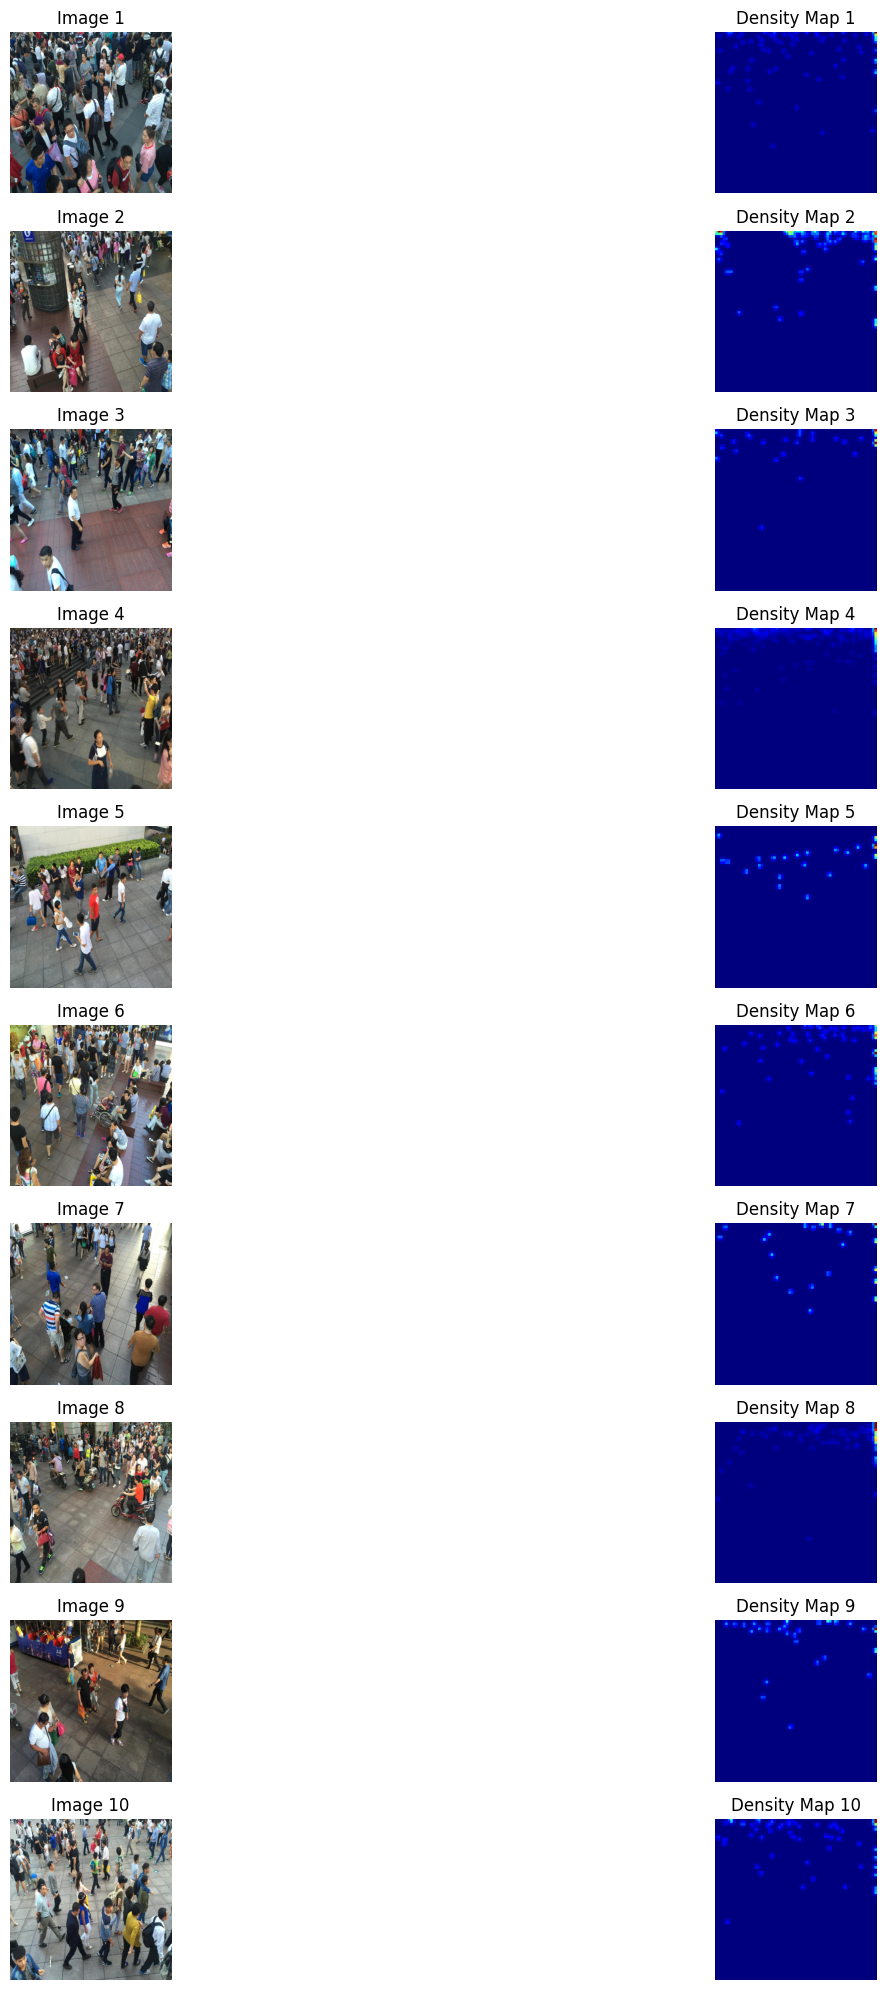

In [1]:
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
from scipy.ndimage import zoom, gaussian_filter
import scipy.io as sio
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# ----------------- CONFIG -----------------
IMG_SIZE = (512, 512)
DATASET_PATH = r"C:\Users\nshre\OneDrive\Desktop\DeepVision\dataset\crowd\part_B"

TRAIN_IMG_PATH = os.path.join(DATASET_PATH, 'train_data', 'images')
TRAIN_GT_PATH = os.path.join(DATASET_PATH, 'train_data', 'ground-truth')

TEST_IMG_PATH = os.path.join(DATASET_PATH, 'test_data', 'images')
TEST_GT_PATH = os.path.join(DATASET_PATH, 'test_data', 'ground-truth')

OUTPUT_PATH = os.path.join(DATASET_PATH, 'processed_crowd')
os.makedirs(OUTPUT_PATH, exist_ok=True)

# ImageNet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# ----------------- PREPROCESS FUNCTIONS -----------------
def preprocess_image(img_path):
    """Load image, resize, scale 0-1, and normalize"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    img = transform(img)
    return img.numpy()

def preprocess_density_map(gt_path, img_shape=(512, 512), sigma=5):
    """Generate density map from head annotations safely"""
    mat = sio.loadmat(gt_path)
    keys = [k for k in mat.keys() if not k.startswith('__')]
    GT_struct = mat[keys[0]]

    # Extract points
    if isinstance(GT_struct, np.ndarray) and GT_struct.dtype == np.object_:
        GT_struct = GT_struct[0,0]
        if hasattr(GT_struct, 'dtype') and GT_struct.dtype.names:
            points = GT_struct['location'][0,0]
        else:
            points = GT_struct
    else:
        points = GT_struct

    h, w = img_shape
    density = np.zeros((h, w), dtype=np.float32)

    # Original image size
    orig_h, orig_w = 1024, 768
    for p in points:
        x = min(int(p[0] * w / orig_w), w-1)
        y = min(int(p[1] * h / orig_h), h-1)
        density[y, x] = 1.0

    density = gaussian_filter(density, sigma=sigma)

    # Downsample by 8x
    downsample_factor = 1/8
    density = zoom(density, (downsample_factor, downsample_factor), order=1)
    density = density * 64  # preserve counts
    return density

# ----------------- PROCESS DATASET -----------------
def process_dataset(img_folder, gt_folder, prefix):
    img_files = sorted([os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.endswith(('.jpg', '.png'))])
    gt_files = sorted([os.path.join(gt_folder, f) for f in os.listdir(gt_folder) if f.endswith('.mat')])

    images_list = []
    gts_list = []

    for img_path, gt_path in tqdm(zip(img_files, gt_files), total=len(img_files), desc=f'Processing {prefix}'):
        img = preprocess_image(img_path)
        gt = preprocess_density_map(gt_path)
        images_list.append(img)
        gts_list.append(gt)

    images_array = np.stack(images_list)
    gts_array = np.stack(gts_list)

    np.save(os.path.join(OUTPUT_PATH, f'{prefix}_images.npy'), images_array)
    np.save(os.path.join(OUTPUT_PATH, f'{prefix}_gts.npy'), gts_array)

    print(f"{prefix} images shape: {images_array.shape}")
    print(f"{prefix} gts shape: {gts_array.shape}")

# Run preprocessing
process_dataset(TRAIN_IMG_PATH, TRAIN_GT_PATH, 'train')
process_dataset(TEST_IMG_PATH, TEST_GT_PATH, 'test')

# ----------------- VISUALIZE RANDOM SAMPLES -----------------
def visualize_random_samples(num_samples=10):
    train_images = np.load(os.path.join(OUTPUT_PATH, 'train_images.npy'))
    train_gts = np.load(os.path.join(OUTPUT_PATH, 'train_gts.npy'))

    indices = random.sample(range(train_images.shape[0]), num_samples)
    plt.figure(figsize=(20, num_samples*2))

    for i, idx in enumerate(indices):
        image = train_images[idx]
        density_map = train_gts[idx]

        # Convert image from [3,H,W] to [H,W,3]
        image_disp = np.transpose(image, (1, 2, 0))
        image_disp = (image_disp * np.array(imagenet_std) + np.array(imagenet_mean))
        image_disp = np.clip(image_disp, 0, 1)

        # Resize density map to 512x512
        density_map_resized = np.kron(density_map, np.ones((8,8)))

        # Plot image
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(image_disp)
        plt.title(f"Image {i+1}")
        plt.axis('off')

        # Plot density map
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(density_map_resized, cmap='jet')
        plt.title(f"Density Map {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 10 random samples
visualize_random_samples(num_samples=10)
